# Possible multi TIC 52368076

Teff: 5154.0 K Logg: 4.47

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np
import astropy.units as u
from glob import glob

paths = glob('52368076/hlsp_*.fits')

files = [fits.getdata(path) for path in paths]

headers = [fits.getheader(path) for path in paths]

In [3]:
from scipy.stats import binned_statistic
import sys
sys.path.insert(0, '/Users/bmmorris/git/gravdark/')

from gravdark import LightCurve

In [4]:
lcs = [LightCurve(times=f['TIME'][~np.isnan(f["TIME"]) & ~np.isnan(f["PDCSAP_FLUX"]) & (f['PDCSAP_FLUX'] != 0)], 
                  fluxes=f['PDCSAP_FLUX'][~np.isnan(f["TIME"])& ~np.isnan(f["PDCSAP_FLUX"]) & (f['PDCSAP_FLUX'] != 0)], 
                  name=header['OBJECT']) for f, header in zip(files, headers)]

from gravdark import concatenate_light_curves

lc = concatenate_light_curves(lcs)

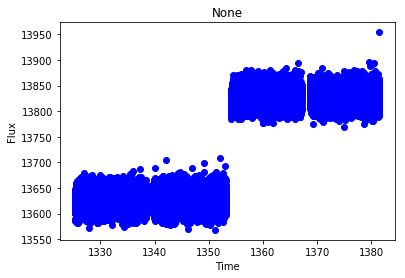

In [5]:
lc.plot()

In [6]:
from batman import TransitParams, TransitModel

In [7]:
paramsb = TransitParams()
paramsb.per = 4.653811
paramsb.t0 = 1327.432906
paramsb.duration = 4/24
paramsb.rp = 0.0292
paramsb.a  = 12.1
paramsb.u = [0.5971, 0.1172]
paramsb.limb_dark = 'quadratic'
paramsb.w = 90
paramsb.inc = 90
paramsb.ecc = 0

paramsc = TransitParams()
paramsc.per = 9.150607
paramsc.inc = 90
paramsc.t0 = 1334.45669
paramsc.duration = 4/24
paramsc.rp = 0.0291
paramsc.a = 23.39
paramsc.u = [0.5971, 0.1172]
paramsc.limb_dark = 'quadratic'
paramsc.w = 90
paramsc.ecc = 0

In [8]:
# Skip partial transits
transitsb = LightCurve(**lc.mask_out_of_transit(paramsb, oot_duration_fraction=2)
                      ).get_transit_light_curves(paramsb)[:-1]
transitsc = LightCurve(**lc.mask_out_of_transit(paramsc, oot_duration_fraction=2)
                      ).get_transit_light_curves(paramsc)[1:]

In [9]:
import emcee
from copy import deepcopy
from corner import corner

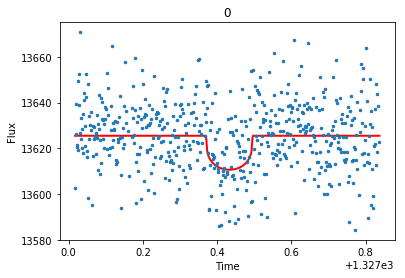

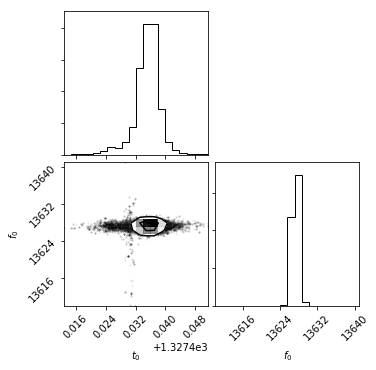

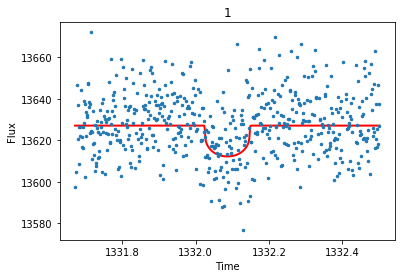

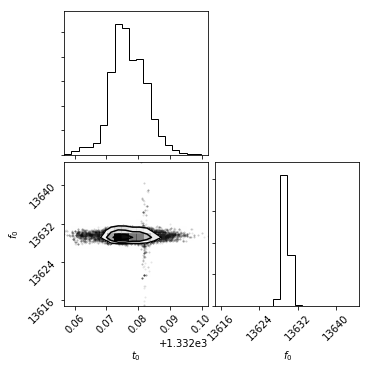

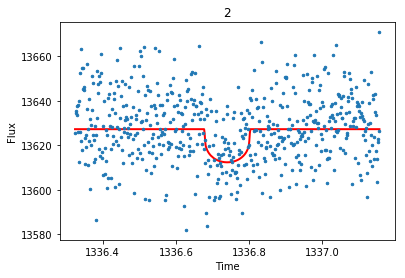

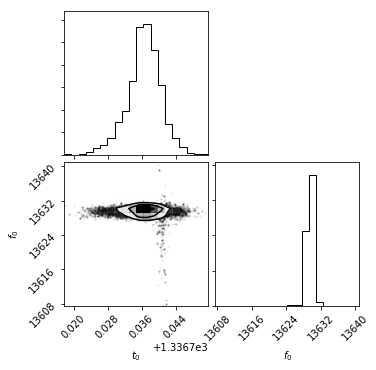

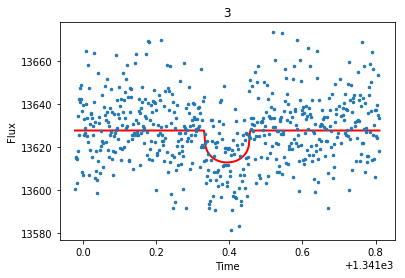

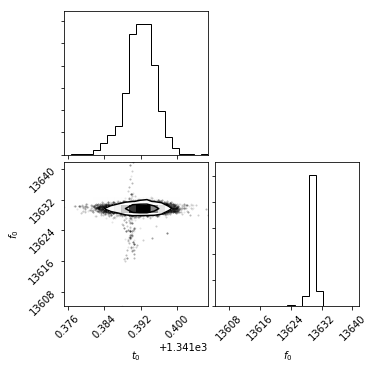

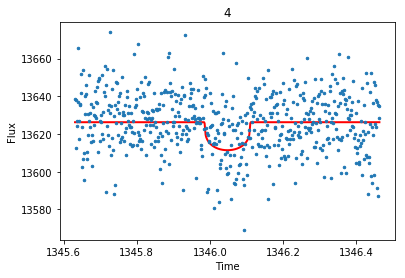

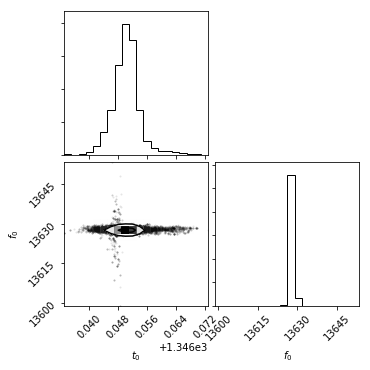

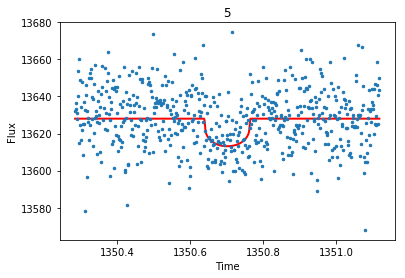

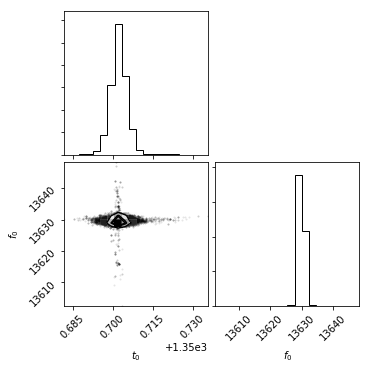

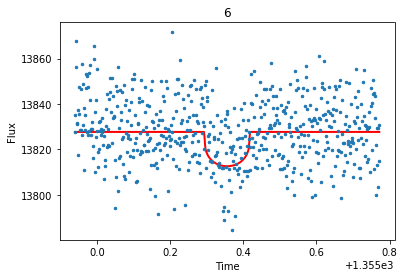

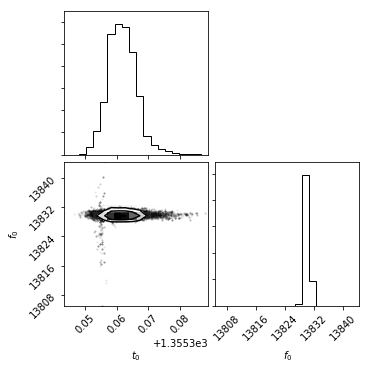

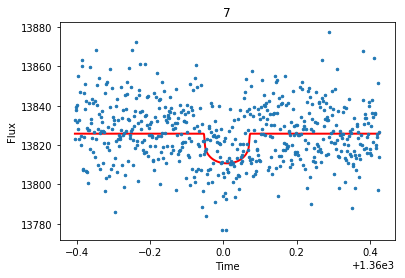

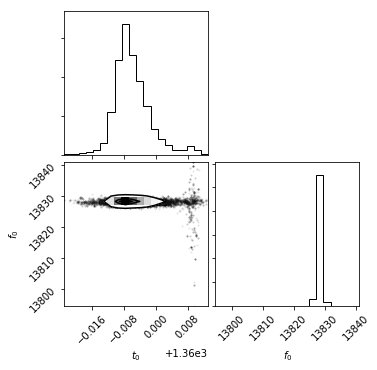

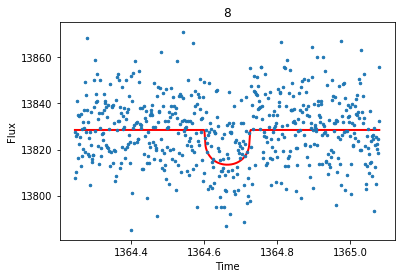

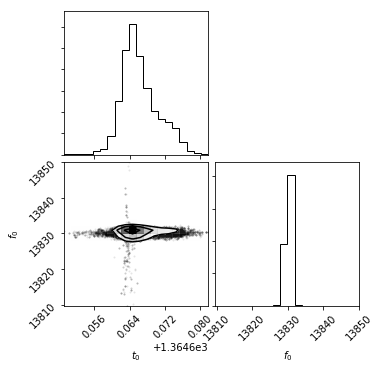

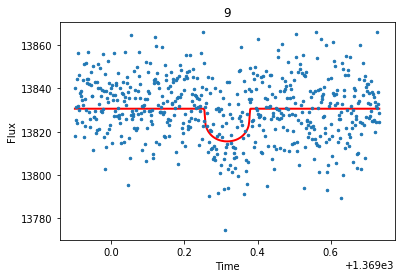

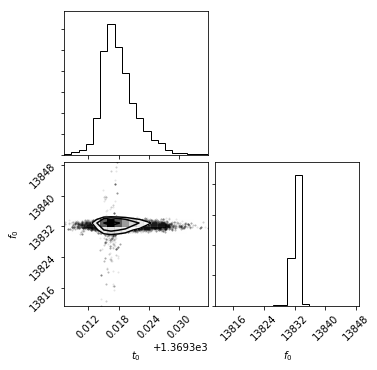

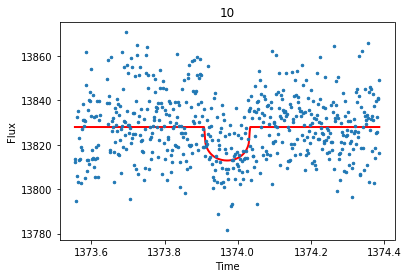

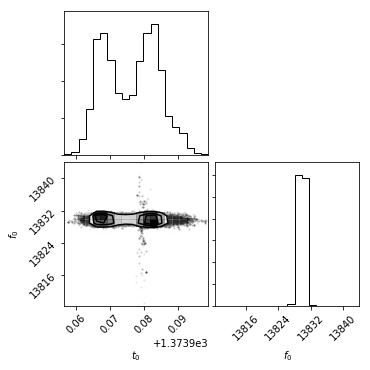

In [17]:
transit_times_b = []

for transit in transitsb:
    m = TransitModel(paramsb, transit.times.jd)
    model = m.light_curve(paramsb)
    plt.plot(transit.times.jd, model * np.median(transit.fluxes), lw=2, color='r')    
    transit.plot(plot_kwargs=dict(ms=5, marker='.', lw=0))
    plt.show()
    
    def lnlike(p, yerr=np.nanstd(transit.fluxes)):
        t0, f0 = p
        
        params = deepcopy(paramsb)
        params.t0 = t0
        m = TransitModel(params, transit.times.jd)
        model = f0*m.light_curve(params)
    
        return -0.5 * np.sum( (transit.fluxes - model)**2 / yerr**2 )
    
    ndim, nwalkers = 2, 30
    
    initp = [np.array([transit.times.jd.mean(), np.median(transit.fluxes)]) + 
             np.array([1e-3 * np.random.randn(), 10*np.random.randn()]) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, threads=8)
    sampler.run_mcmc(initp, 5000)
    sampler.reset()
    sampler.run_mcmc(initp, 1000)
    
    corner(sampler.flatchain, labels=["$t_0$", "$f_0$"])
    plt.show()
    
    transit_times_b.append([np.median(sampler.flatchain[:, 0]), 
                            np.std(sampler.flatchain[:, 0])])
    sampler.pool.close()

In [18]:
np.save('transit_times_b.npy', np.vstack(transit_times_b).T)

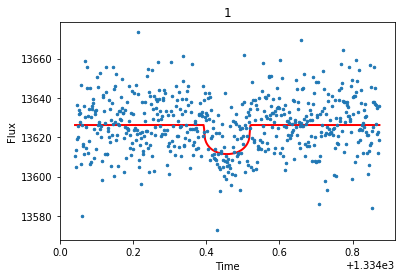

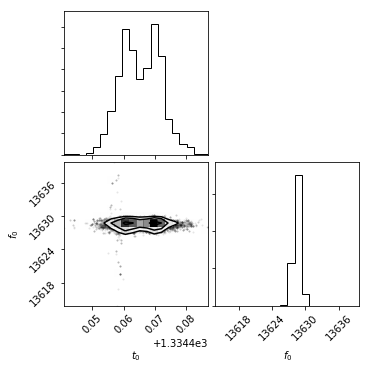

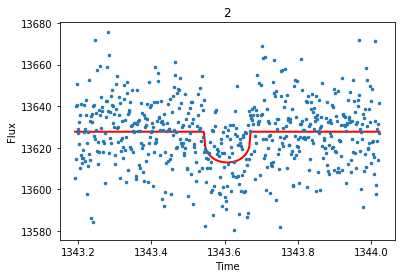

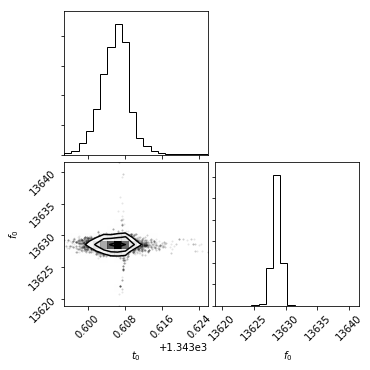

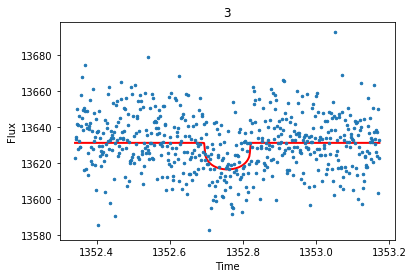

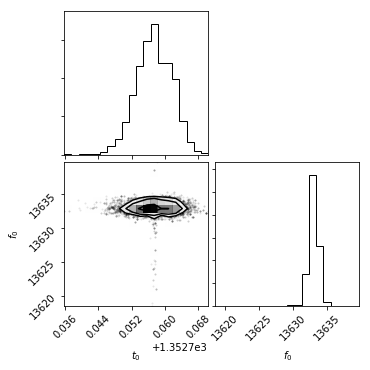

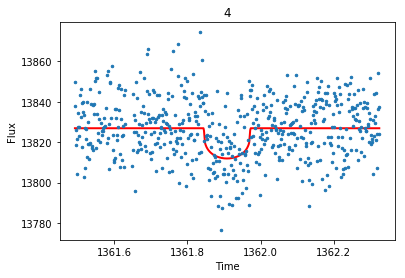

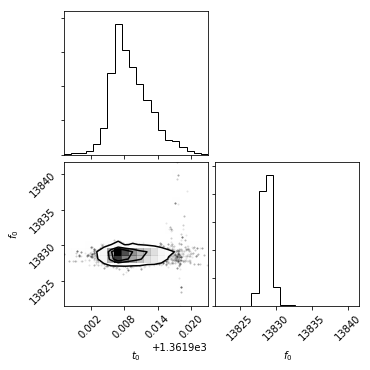

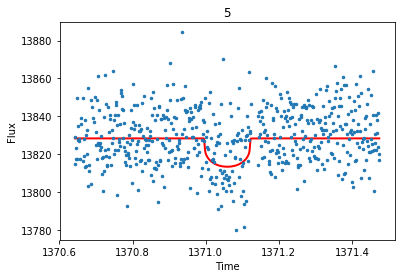

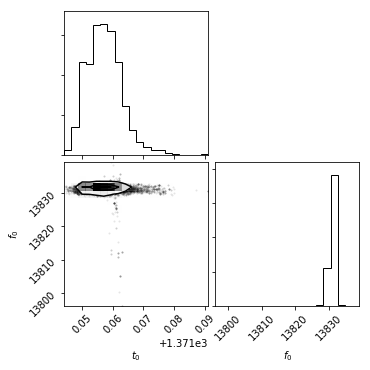

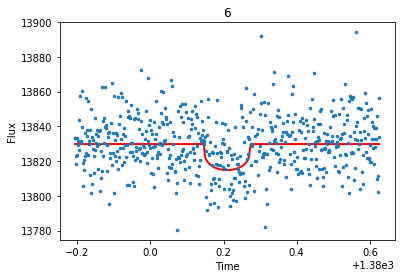

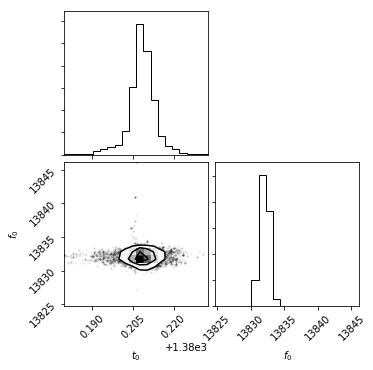

In [13]:
transit_times_c = []

for transit in transitsc:
    m = TransitModel(paramsc, transit.times.jd)
    model = m.light_curve(paramsc)
    plt.plot(transit.times.jd, model * np.median(transit.fluxes), lw=2, color='r')    
    transit.plot(plot_kwargs=dict(ms=5, marker='.', lw=0))
    plt.show()
    
    def lnlike(p, yerr=np.nanstd(transit.fluxes)):
        t0, f0 = p
        
        params = deepcopy(paramsc)
        params.t0 = t0
        m = TransitModel(params, transit.times.jd)
        model = f0*m.light_curve(params)
    
        return -0.5 * np.sum( (transit.fluxes - model)**2 / yerr**2 )
    
    ndim, nwalkers = 2, 10
    
    initp = [np.array([transit.times.jd.mean(), np.median(transit.fluxes)]) + 
             np.array([1e-3 * np.random.randn(), 10*np.random.randn()]) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnlike, threads=8)
    sampler.run_mcmc(initp, 5000)
    sampler.reset()
    sampler.run_mcmc(initp, 1000)
    
    corner(sampler.flatchain, labels=["$t_0$", "$f_0$"])
    plt.show()
    
    transit_times_c.append([np.median(sampler.flatchain[:, 0]), 
                            np.std(sampler.flatchain[:, 0])])
    sampler.pool.close()

In [16]:
np.save('transit_times_c.npy', np.vstack(transit_times_c).T)